In [229]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from tqdm.notebook import tqdm

In [230]:
af_dir = Path("/mnt/db/af_disorder")

In [231]:
disorder_disprot = dict()
with open("data/references/disorder_ref.fasta", "r") as f:
    for line in f:
        if line.startswith(">"):
            name = line[1:].strip()
            f.readline()
            disorder_disprot[name] = f.readline().strip()

In [241]:
af = {
        "name": [],
        "pos" : [],
        "aa"  : [],
        "lddt": [],
}

already_in = set()

for file in af_dir.glob("*data.tsv"):
    print(file)
    with open(file, "r") as f:
        # Skip header
        f.readline()
        for line in f:
            name, pos, aa, lddt, *_ = line.split('\t')
            name = name.split('-')[1]
            if name in disorder_disprot.keys() and (name, pos) not in already_in:
                af["name"].append(name)
                af["pos"].append(int(pos))
                af["aa"].append(aa)
                af["lddt"].append(float(lddt))
                already_in.add((name, pos))

/mnt/db/af_disorder/UP000008816_93061_STAA8_v3_data.tsv
/mnt/db/af_disorder/UP000001014_99287_SALTY_v3_data.tsv
/mnt/db/af_disorder/swissprot_cif_v3_data.tsv
/mnt/db/af_disorder/UP000270924_6293_WUCBA_v3_data.tsv
/mnt/db/af_disorder/UP000000429_85962_HELPY_v3_data.tsv
/mnt/db/af_disorder/UP000030665_36087_TRITR_v3_data.tsv
/mnt/db/af_disorder/UP000000586_171101_STRR6_v3_data.tsv
/mnt/db/af_disorder/UP000000589_10090_MOUSE_v3_data.tsv
/mnt/db/af_disorder/UP000000437_7955_DANRE_v3_data.tsv
/mnt/db/af_disorder/UP000006548_3702_ARATH_v3_data.tsv
/mnt/db/af_disorder/UP000053029_1442368_9EURO2_v3_data.tsv
/mnt/db/af_disorder/UP000000803_7227_DROME_v3_data.tsv
/mnt/db/af_disorder/UP000006304_1133849_9NOCA1_v3_data.tsv
/mnt/db/af_disorder/UP000274756_318479_DRAME_v3_data.tsv
/mnt/db/af_disorder/UP000035681_6248_STRER_v3_data.tsv
/mnt/db/af_disorder/UP000000799_192222_CAMJE_v3_data.tsv
/mnt/db/af_disorder/UP000007841_1125630_KLEPH_v3_data.tsv
/mnt/db/af_disorder/UP000325664_1352_ENTFC_v3_data.t

In [242]:
af = pd.DataFrame(af)

In [243]:
af.to_csv("data/af_disorder.csv", index=False, mode="w")

In [244]:
af = pd.read_csv("data/af_disorder.csv")

In [245]:
print(f"In AF there are {len(disorder_disprot) - len(af.name.unique())} protein missing from the disorder dataset")

In AF there are 391 protein missing from the disorder dataset


In [246]:
(af.lddt > 0.7).sum() / len(af)

0.6497000032285714

Text(0, 0.5, 'Number of proteins')

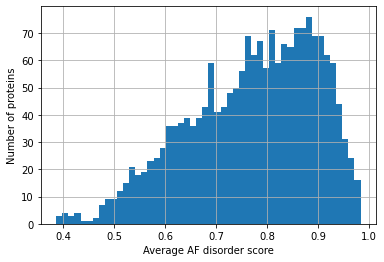

In [247]:
ax = af.groupby(["name"]).mean().lddt.hist(bins=50)
ax.set_xlabel("Average AF disorder score")
ax.set_ylabel("Number of proteins")

In [248]:
with open("data/references/disorder_af_ref.fasta", "w") as f:
    for name in tqdm(af.name.unique()):
        f.write(f">{name}\n")
        order = (af[af.name == name].lddt > 0.7).astype(int)
        f.write(f"{''.join(order.astype(str))}\n")

  0%|          | 0/1876 [00:00<?, ?it/s]

In [173]:
sifts_file = Path("data/uniprot_segments_observed.tsv")
df_sifts = pd.read_csv(sifts_file, sep="\t", header=1, usecols=["SP_PRIMARY", "SP_BEG", "SP_END"])
df_sifts.columns = ["uniprot", "start", "end"]
# Filter for dataset entries
df_sifts = df_sifts.loc[df_sifts['uniprot'].isin(disorder_disprot.keys())]

,uniprot,start,end
19,P17931,113,250
65,Q9W1M7,291,422
66,Q9W1M7,531,561
67,Q9W1M7,566,948
68,Q9W1M7,292,421
...,...,...,...
972217,P47047,4,17
972220,P38801,1,101
972221,P47047,5,12
972224,P38801,2,94


In [218]:
ids_in_sifts = set(df_sifts.uniprot.unique())
with open(f"data/references/disorder_pdb_ref.fasta", "w") as f:
    for record_id, sequence in disorder_disprot.items():
        if record_id in ids_in_sifts:
            s, e = df_sifts.loc[df_sifts.uniprot == record_id, ["start", "end"]].values[0]
            order = ""
            for idx in range(len(sequence)):
                idx = idx + 1
                if s <= idx <= e:
                    order += "1"
                else:
                    order += "0"
            f.write(f">{record_id}\n")
            f.write(f"{order}\n")

In [249]:
disorder_pdb = dict()
disorder_af = dict()

for record in SeqIO.parse("data/references/disorder_pdb_ref.fasta", 'fasta'):
    disorder_pdb[record.id] = record

for record in SeqIO.parse("data/references/disorder_af_ref.fasta", 'fasta'):
    disorder_af[record.id] = record

In [266]:
x = np.array([int(x) for x in disorder_af["P49765"].seq])
y = np.array([int(x) for x in disorder_pdb["P49765"].seq])
z = np.array([int(x) for x in disorder_disprot["P49765"]])

<AxesSubplot:>

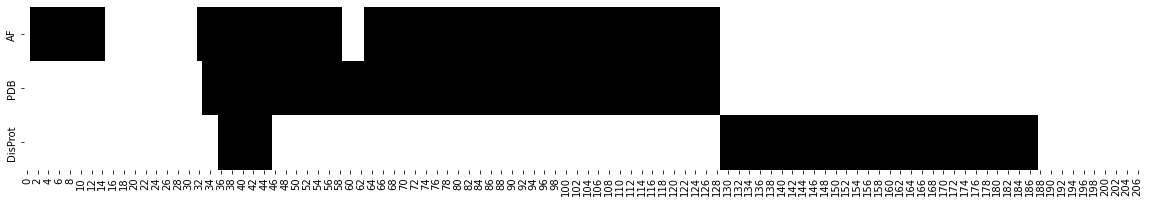

In [267]:
plt.subplots(figsize=(20, 3))
sns.heatmap(np.stack([x, y, z], axis=0), cmap="Greys", cbar=False, yticklabels=["AF", "PDB", "DisProt"])

In [222]:
disorder_disprot["O33599"].__len__()


316

In [228]:
disorder_af["O33599"].seq.__len__()

632